##Código

###Importações de biblioteca 

In [ ]:
import os
import os.path as path
import random
import copy
import shutil
import zipfile
import google.colab.files as files
import google.colab.drive as drive
import numpy as np
import imageio as iio
import matplotlib.pyplot as plt
import cv2
import scipy.stats as stats
import scipy.ndimage as ndimage
import skimage.filters as filters
import csv
import pandas as pd
import sklearn.model_selection as model_selection
from sklearn.utils import shuffle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
%matplotlib inline

###Definição de variáveis

In [ ]:
# for reference on folder structure used:
# https://drive.google.com/drive/folders/1NPapFjH737Hkw9Fm-hp4Swlh4y8N_g7R?usp=sharing
# and archive.zip used for this code is available in:
# https://www.kaggle.com/datasets/praveen2084/leather-defect-classification

# mound drive files
drive.mount('/content/drive',force_remount=True)

# Working directory for images
WorkDir = "/content/drive/MyDrive/LeatherDefect"

# variable that defines how blurry the images will get
sigma = 8

# Nº of pixels that the image will have after being resized on axis X and Y
resizedImageX = 224
resizedImageY = resizedImageX

# Nº de pixels das peças depois de cortadas nos eixos X e Y
cutM = 56
cutN = cutM

# Quantidade de peças feitas da imagem
imagecount = int(resizedImageX/cutM * resizedImageY/cutN)

# Count of different data that should be created from the images, call it combo
# Theoretical total is 2156400 image combos with both good-good and bad-good minus same good combinations,
# complete dataset lenght = FlawedBagImagesCount * GoodBagImagesCount
FlawBagImagesCount = 1000 #max = len(os.listdir(WorkDir+"/Images/Flawed"))
GoodBagImagesCount = 500 #max = len(os.listdir(WorkDir+"/Images/Good"))

# In percentage, how many of the combos should be used for learning, being for testing = 1-LearningSplit
LearningSplit = 0.8

DatasetUsed = 'dataset_'+str(sigma)+'_'+str(cutM)+'_'+str(FlawBagImagesCount)+'_'+str(GoodBagImagesCount)+'_'+str(LearningSplit*100)+'.csv'
print(DatasetUsed)


Mounted at /content/drive
dataset_8_56_1000_500_80.0.csv


### Importar imagens

In [ ]:
def OrganizeImages():
  count = 1
  NonDefCount = 1
  OriginalImagesDir = WorkDir+"/OriginalFiles/Leather Defect Classification"
  for folder_name in os.listdir(OriginalImagesDir):
    for file_name in os.listdir(OriginalImagesDir+"/"+folder_name):
      if(folder_name == "non defective"):
        #create copy of non-defective to be used as good
        source = OriginalImagesDir +"/"+ folder_name +"/"+ file_name
        altdestination = WorkDir+"/Images/Good/image_" + str(NonDefCount) + ".jpg"
        shutil.copy(source, altdestination)
        NonDefCount += 1
      else:
        #create copy of all images to be used as Flawed bag
        source = OriginalImagesDir +"/"+ folder_name +"/"+ file_name
        destination = WorkDir+"/Images/Flawed/image_" + str(count) + ".jpg"
        shutil.copy(source, destination)
        count += 1

In [ ]:
# Check if data structure exists or not
if(path.exists(WorkDir+"/OriginalFiles") and path.exists(WorkDir+"/Images")):
  print("assuming structure existent")
else:
  print("assuming structure non-existent")
  if(path.exists(WorkDir+"/archive.zip")):
    print("creating needed structure")
    os.mkdir(WorkDir+"/Images")
    os.mkdir(WorkDir+"/Dataset")
    os.mkdir(WorkDir+"/OriginalFiles")
    os.mkdir(WorkDir+"/Images/Flawed")
    os.mkdir(WorkDir+"/Images/Good")
    shutil.move(WorkDir+"/archive.zip",WorkDir+"/OriginalFiles/archive.zip")
    zip_ref = zipfile.ZipFile(WorkDir+"/OriginalFiles/archive.zip", 'r')
    zip_ref.extractall(WorkDir+"/OriginalFiles")
    zip_ref.close()
    print("organizing and creating copies of original images")
    OrganizeImages()
  else:
    print('please add "arquive.zip" file inside working directory and re-run this cell.')

assuming structure existent


### Definição de funções

In [ ]:
# Converção pra escala de cinza
def ImageToGray(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return gray

# Aplicação do filtro Gaussiano
def ImageBlur(image,sigma):
  blurred_float64 = filters.gaussian(image, sigma=sigma)
  blurred = cv2.multiply(blurred_float64,256).astype(np.uint8)
  return blurred

# Redimencionar as imagens
def ResizeImage(image,X,Y):
  resized = cv2.resize(image, dsize=(X, Y), interpolation=cv2.INTER_CUBIC)
  return resized

# Segmentar das imagens em partes menores
def CutImage(image,tileX,tileY):
  tiles = [image[x:x+tileX,y:y+tileY] for x in range(0,image.shape[0],tileX) for y in range(0,image.shape[1],tileY)]
  return tiles

# Cálculo das características de cada peça de ambas imagens
def GetStats(tiles,imagecount):
  # estruture = [[mean],[variance],[q1],[q3],[skew],[kurtosis]]
  ImageStats = [[],[],[],[],[],[]]
  for i in range(imagecount):
    tile = tiles[i]
    ImageStats[0].append(np.mean(tile))
    ImageStats[1].append(np.var(tile))
    ImageStats[2].append(np.quantile(tile,.25))
    ImageStats[3].append(np.quantile(tile,.75))
    ImageStats[4].append(stats.skew(tile.flatten()))
    ImageStats[5].append(stats.kurtosis(tile.flatten()))
  return ImageStats

# Função unica que realiza todos os passos anteriores
def TreatmentAlgorithm(image):
  grayd = ImageToGray(image)
  blurr = ImageBlur(grayd,sigma)
  resiz = ResizeImage(blurr,resizedImageX,resizedImageY)
  tiled = CutImage(resiz,cutM,cutN)
  stats = GetStats(tiled,imagecount)
  return stats

# Realizar teste de KS
def GetKSTest(ImageStatsFlaw,ImageStatsGood):
  ks_stats,ks_pvalues = [],[]
  for i in range(6):
    ks_stat,ks_pvalue = stats.kstest(ImageStatsFlaw[i],ImageStatsGood[i])
    ks_stats.append(ks_stat)
    ks_pvalues.append(ks_pvalue)
  return ks_pvalues
  # valores maiores que 0.05 = são imagens parecidas (hipotese nula não descartada)
  # valores menores que 0.05 = são imagens diferentes (hipotese nula não descartada)

# Redução da dimensionalidade do recurso


# Aquisição de métricas
def getMetrics(tn, fp, fn, tp):
  metrics = {
      "Sensitivity": tp/(tp+fn),
      "Specificity": tn/(tn+fp),
      "Precision": tp/(tp+fp),
      "F1-score": (2 * (tp/(tp+fp)) * (tp/(tp+fn)))/((tp/(tp+fp)) + (tp/(tp+fn))),
      "Error rate": (fp+fn)/(tp+tn+fp+fn),
      "Accuracy": (tp+tn)/(tp+tn+fp+fn)
      }
  return metrics

###Criação do dataset

In [ ]:
if(not path.exists(WorkDir+"/Dataset/"+DatasetUsed)):
  #Randomize items in FlawBag
  FlawBagFilesDir = WorkDir+"/Images/Flawed"
  ListOfFlaw = random.sample(range(1,len(os.listdir(FlawBagFilesDir))+1),FlawBagImagesCount)

  #Randomize items in GoodBag
  GoodBagFilesDir = WorkDir+"/Images/Good"
  ListOfGood = random.sample(range(1,len(os.listdir(GoodBagFilesDir))+1),GoodBagImagesCount)

  #Create CSV file
  datasetCSV = open(WorkDir+'/Dataset/'+DatasetUsed, 'w')
  datasetWriter = csv.writer(datasetCSV)
  header = ['FlawBag','GoodBag','IsGood','meanPValue', 'variancePValue', 'q1PValue', 'q3PValue', 'skewnessPValue', 'kurtosisPValue']
  datasetWriter.writerow(header)

  for i, currGood in enumerate(ListOfGood):
    GoodImage = cv2.imread(GoodBagFilesDir+"/image_"+str(ListOfGood[i])+".jpg")
    currGoodImageStats = TreatmentAlgorithm(GoodImage)
    print("processando imagem "+str(i+1)+"/"+str(GoodBagImagesCount)+" - image_"+str(ListOfGood[i])+".jpg")
    # add false-true comparisons
    for j, currFlaw in enumerate(ListOfFlaw):
      FlawImage = cv2.imread(FlawBagFilesDir+"/image_"+str(ListOfFlaw[j])+".jpg")
      currFlawImageStats = TreatmentAlgorithm(FlawImage)
      currKSTestPvalues = GetKSTest(currFlawImageStats,currGoodImageStats)
      row = np.array("f"+[int(ListOfFlaw[j]),int(ListOfGood[i]),False,currKSTestPvalues[0],currKSTestPvalues[1],currKSTestPvalues[2],currKSTestPvalues[3],currKSTestPvalues[4],currKSTestPvalues[5]])
      datasetWriter.writerow(row)
    # add true-true comparisons
    for j, currGood2 in enumerate(ListOfGood):
      Good2Image = cv2.imread(GoodBagFilesDir+"/image_"+str(ListOfGood[j])+".jpg")
      currGood2ImageStats = TreatmentAlgorithm(Good2Image)
      currKSTestPvalues = GetKSTest(currGood2ImageStats,currGoodImageStats)
      row = np.array("g"+[int(ListOfGood[j]),int(ListOfGood[i]),True,currKSTestPvalues[0],currKSTestPvalues[1],currKSTestPvalues[2],currKSTestPvalues[3],currKSTestPvalues[4],currKSTestPvalues[5]])
      datasetWriter.writerow(row)
  print("Arquivo CSV criado")
else:
  print("assuming dataset existence")

assuming dataset existence


### Partição do dataset entre dados de treino e teste

In [ ]:
#Complete dataset from CSV file
CompleteDataset = pd.read_csv(WorkDir+"/Dataset/"+DatasetUsed)

#Split and shuffle of the data in train and test data
TrainData, TestData = model_selection.train_test_split(CompleteDataset,test_size=1-LearningSplit)
TrainData = TrainData.reset_index(drop=True)
TestData = TestData.reset_index(drop=True)

#Preparing training data input and result
TrainDataInput = TrainData[["meanPValue", "variancePValue","q1PValue","q3PValue","skewnessPValue","kurtosisPValue"]]
TrainDataResult = TrainData["IsGood"]
TrainData.head()

#Preparing test data input and result
TestDataInput = TestData[["meanPValue", "variancePValue","q1PValue","q3PValue","skewnessPValue","kurtosisPValue"]]
TestDataResult = TestData["IsGood"]
TestData.head()

,FlawBag,GoodBag,IsGood,meanPValue,variancePValue,q1PValue,q3PValue,skewnessPValue,kurtosisPValue
0,67.0,478.0,1.0,3.327342e-09,1.064749e-07,3.327342e-09,3.327342e-09,0.716412,0.214535
1,690.0,165.0,0.0,3.327342e-09,1.064749e-07,3.327342e-09,3.327342e-09,0.214535,0.000017
2,132.0,125.0,0.0,3.327342e-09,2.145346e-01,3.327342e-09,3.327342e-09,0.952256,0.426293
3,202.0,544.0,1.0,9.522563e-01,9.998910e-01,9.522563e-01,9.522563e-01,0.999891,0.952256
4,775.0,264.0,0.0,3.327342e-09,3.015211e-03,3.327342e-09,3.327342e-09,0.716412,0.093326


### Classificação

* Discriminant analysis
* Naive Bayes
* Decision tree
* K Nearest Neighbours
* Multi-Layered Perceptron

In [ ]:
# Defining classifiers
lda = LinearDiscriminantAnalysis()
gnb = GaussianNB()
dtc = DecisionTreeClassifier()
knn = KNeighborsClassifier()
mlp = MLPClassifier(max_iter=500, learning_rate_init=0.0002)

classifiers = [lda,gnb,dtc,knn,mlp]
metrics = np.array([])

for index, classifier in enumerate(classifiers):
  classifier.fit(TrainDataInput, TrainDataResult)
  prediction = classifier.predict(TestDataInput)
  class_tn,class_fp,class_fn,class_tp = confusion_matrix(TestDataResult.to_numpy(),prediction).ravel()
  metrics = np.append(metrics,getMetrics(class_tn,class_fp,class_fn,class_tp))
lda_metrics,gnb_metrics,dtc_metrics,knn_metrics,mlp_metrics = metrics

###Metricas de Desempenho

* Sensitivity
* Specificity
* Precision
* F1-score
* Error rate
* Accuracy

In [ ]:
print("  Dados para treino = "+str(len(TrainDataInput))+", Dados para teste = "+str(len(TestDataInput)))
all_metrics = copy.deepcopy([lda_metrics,gnb_metrics,dtc_metrics,knn_metrics,mlp_metrics])
for classifier in all_metrics:
  for metric in classifier:
    classifier[metric] = str(round(classifier[metric]*100, 2))+"%"
results = pd.DataFrame(all_metrics, columns = ['Sensitivity','Specificity','Precision','F1-score','Error rate','Accuracy'])
index = pd.Index(['lda','gnb','dtc','knn','mlp'])
results = results.set_index(index)
print(results)

  Dados para treino = 599830, Dados para teste = 149958
    Sensitivity Specificity Precision F1-score Error rate Accuracy
lda      15.94%      97.45%     75.7%   26.34%     29.66%   70.34%
gnb      16.87%      96.99%    73.61%   27.45%     29.67%   70.33%
dtc      34.48%      96.88%    84.64%    49.0%     23.88%   76.12%
knn      43.86%      84.46%    58.45%   50.11%     29.05%   70.95%
mlp      24.86%      95.14%    71.85%   36.94%     28.24%   71.76%


## Teste de imagem


Saving Growth mark01 (579).jpg to Growth mark01 (579).jpg


(-0.5, 226.5, 226.5, -0.5)

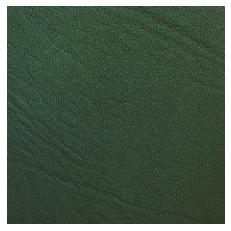

In [ ]:
upload = files.upload()
caminho = f"/content/{list(upload.keys())[0]}"
imagemDeTeste = iio.imread(caminho)
plt.imshow(imagemDeTeste)
plt.axis('off')

(-0.5, 226.5, 226.5, -0.5)

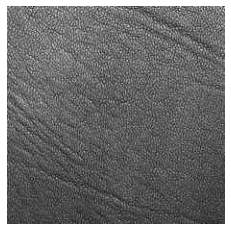

In [ ]:
cinza = ImageToGray(imagemDeTeste)
plt.imshow(cinza,cmap="gray")
plt.axis('off')

(-0.5, 226.5, 226.5, -0.5)

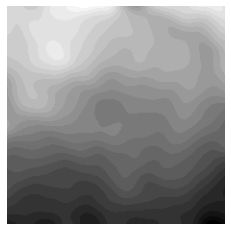

In [ ]:
borrado = ImageBlur(cinza,sigma)
plt.imshow(borrado,cmap="gray")
plt.axis('off')

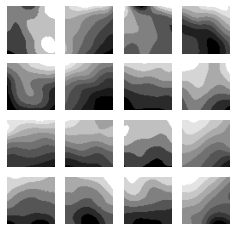

In [ ]:
redimens = ResizeImage(borrado,resizedImageX,resizedImageY)
pedacos = CutImage(redimens,cutM,cutN)
sub = plt.figure(figsize=(4, 4))
for index, pedaco in enumerate(pedacos):
  sub.add_subplot(resizedImageX/cutM,resizedImageY/cutN,index+1)
  plt.imshow(pedaco,cmap="gray")
  plt.axis('off')

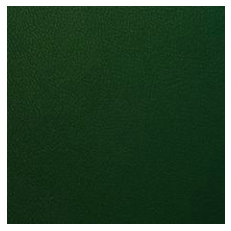

In [ ]:
ImagemBoa = cv2.imread(WorkDir+"/Images/Good/image_"+str(random.sample(range(1,len(os.listdir(WorkDir+"/Images/Good"))+1),1)[0])+".jpg")
plt.imshow(ImagemBoa)
plt.axis('off')
ImagemBoaVetores = TreatmentAlgorithm(ImagemBoa)

In [ ]:
vetores = GetStats(pedacos,imagecount)
numpyKSTest = np.array(GetKSTest(vetores,ImagemBoaVetores))
KSTestPvalues = pd.DataFrame([numpyKSTest], columns = ['meanPValue', 'variancePValue','q1PValue','q3PValue','skewnessPValue','kurtosisPValue'])
print(KSTestPvalues)


     meanPValue  variancePValue      q1PValue      q3PValue  skewnessPValue  \
0  3.327342e-09        0.093326  3.327342e-09  3.327342e-09        0.426293   

   kurtosisPValue  
0        0.426293  


In [ ]:
print("lda says Defective" if lda.predict(KSTestPvalues) == 0 else "lda says Non-Defective")
print("gnb says Defective" if gnb.predict(KSTestPvalues) == 0 else "gnb says Non-Defective")
print("dtc says Defective" if dtc.predict(KSTestPvalues) == 0 else "dtc says Non-Defective")
print("knn says Defective" if mlp.predict(KSTestPvalues) == 0 else "knn says Non-Defective")
print("mlp says Defective" if knn.predict(KSTestPvalues) == 0 else "mlp says Non-Defective")

lda says Defective
gnb says Defective
dtc says Defective
knn says Defective
mlp says Non-Defective
